# Setup: connect to the databases

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# db datasets
TAKEAWAY_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db"
UBEREATS_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db"
DELIVEROO_DB = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db"

con_takeaway  = sqlite3.connect(TAKEAWAY_DB)
con_ubereats  = sqlite3.connect(UBEREATS_DB)
con_deliveroo = sqlite3.connect(DELIVEROO_DB)

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)


# 1) Price distribution of menu items

In [11]:
bucket_size = 10

bucket_counts = q(con_takeaway, f"""
SELECT
  (CAST(CAST(price AS REAL) / {bucket_size} AS INT) * {bucket_size}) AS bucket_start,
  (CAST(CAST(price AS REAL) / {bucket_size} AS INT) * {bucket_size}) + {bucket_size} AS bucket_end,
  COUNT(*) AS n_items
FROM menuItems
WHERE price IS NOT NULL
  AND TRIM(price) <> ''
  AND CAST(price AS REAL) > 0
GROUP BY bucket_start
ORDER BY bucket_start;
""")

bucket_counts


,bucket_start,bucket_end,n_items
0,0,10,219742
1,10,20,156712
2,20,30,20678
3,30,40,2489
4,40,50,1028
5,50,60,681
6,60,70,469
7,70,80,329
8,80,90,223
9,90,100,160


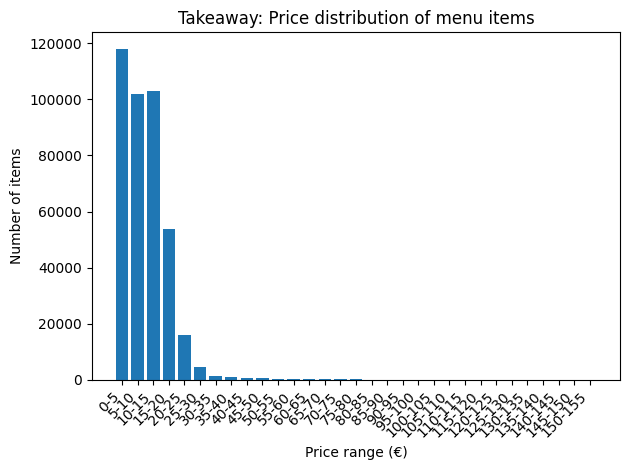

In [12]:
plt.figure()
labels = price_bins_takeaway["bucket_start"].astype(int).astype(str) + "-" + price_bins_takeaway["bucket_end"].astype(int).astype(str)
plt.bar(labels, price_bins_takeaway["n_items"])
plt.title("Takeaway: Price distribution of menu items")
plt.xlabel("Price range (€)")
plt.ylabel("Number of items")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# 2) Distribution of restaurants per location

In [24]:
rest_per_location_takeaway = q(con_takeaway, """
SELECT
  l.ID AS location_id,
  l.city,
  l.postalCode,
  COUNT(DISTINCT lr.restaurant_id) AS restaurants
FROM locations l
JOIN locations_to_restaurants lr
  ON lr.location_id = l.ID
GROUP BY l.ID, l.city, l.postalCode
ORDER BY restaurants DESC;
""")

rest_per_location_takeaway.head()


,location_id,city,postalCode,restaurants
0,1671,Haren,1140,605
1,731,Antwerp,2140,552
2,247,Antwerp,2140,547
3,1096,Antwerp,2600,547
4,2174,Antwerp,2140,546


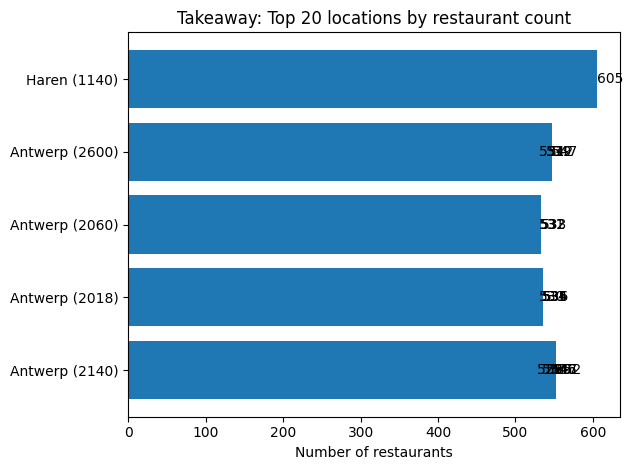

In [23]:
top = rest_per_location_takeaway.head(20).sort_values("restaurants")

plt.figure()
bars = plt.barh(top["city"].astype(str) + " (" + top["postalCode"].astype(str) + ")", top["restaurants"])
plt.title("Takeaway: Top 20 locations by restaurant count")
plt.xlabel("Number of restaurants")
plt.tight_layout()

for bar in bars:
    value = bar.get_width()
    y = bar.get_y() + bar.get_height()/2
    plt.text(value, y, str(int(value)), va="center", ha="left")

plt.show()


# 3) Top 10 pizza restaurants by rating

In [25]:
top_pizza_takeaway = q(con_takeaway, """
SELECT DISTINCT
  restaurant.name,
  restaurant.city,
  restaurant.ratings,
  restaurant.ratingsNumber
FROM restaurants restaurant
JOIN categories_restaurants category_link
  ON category_link.restaurant_id = restaurant.primarySlug
WHERE LOWER(category_link.category_id) LIKE '%pizza%'
  AND restaurant.ratingsNumber > 10
ORDER BY restaurant.ratings DESC
LIMIT 10;
""")

top_pizza_takeaway


,name,city,ratings,ratingsNumber
0,Veziroglu,Vilvorde,5.0,455
1,Trend Kebab & Pizzeria,Maaseik,5.0,165
2,Kebap - Pizza De Brug,Hasselt,5.0,312
3,De Echte Eethuis Carlos,Aarschot,5.0,599
4,Pyramide,Hamont,4.9,45
5,Am Princesse,Schaerbeek,4.9,367
6,Pizzeria Zirar Saint-Denis,Forest,4.9,529
7,Snack Pizzeria Izmir,Vilvoorde,4.9,498
8,De Notenboom,Nieuwpoort,4.9,706
9,Pizza L'Esta,Hoboken,4.9,372


# 4) Map locations offering kapsalons and their average price

In [26]:
kapsalon = q(con_takeaway, """
SELECT
  restaurant.name,
  restaurant.city,
  restaurant.latitude,
  restaurant.longitude,
  AVG(CAST(menu.price AS REAL)) AS avg_kapsalon_price,
  COUNT(*) AS kapsalon_items
FROM menuItems menu
JOIN restaurants restaurant
  ON restaurant.primarySlug = menu.primarySlug
WHERE LOWER(menu.name) LIKE '%kapsalon%'
  AND menu.price IS NOT NULL
GROUP BY restaurant.primarySlug
ORDER BY avg_kapsalon_price DESC;
""")
kapsalon.head()


,name,city,latitude,longitude,avg_kapsalon_price,kapsalon_items
0,Melita Original,Kruishoutem,50.905063,3.528835,22.785714,7
1,Cannur Pizza Pasta Pitta BBQ,Wetteren,51.005845,3.888688,20.844000,10
2,Anatolia Hoogstraten,Hoogstraten,51.396100,4.753590,19.166667,9
3,Flamingo Pizza & Kebap,Merksplas,51.355780,4.865092,17.350000,10
4,Qubbe Lounge,Genk,50.979642,5.491545,16.000000,2


In [27]:
import folium

df = kapsalon.dropna(subset=["latitude","longitude","avg_kapsalon_price"])
if len(df) == 0:
    print("No kapsalon found. Try another dish keyword (e.g., 'hummus' or 'pizza').")
else:
    center = [df["latitude"].mean(), df["longitude"].mean()]
    m = folium.Map(location=center, zoom_start=11)

    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=5,
            popup=f'{row["name"]} | avg €{row["avg_kapsalon_price"]:.2f} | items: {int(row["kapsalon_items"])}',
            fill=True
        ).add_to(m)

    m


# 1) Best price-to-rating ratio (Takeaway)

In [28]:
price_to_rating = q(con_takeaway, """
WITH avg_price AS (
  SELECT
    primarySlug AS restaurant_slug,
    AVG(CAST(price AS REAL)) AS avg_item_price
  FROM menuItems
  WHERE price IS NOT NULL AND CAST(price AS REAL) > 0
  GROUP BY primarySlug
)
SELECT
  r.name,
  r.city,
  r.ratings,
  r.ratingsNumber,
  ap.avg_item_price,
  (r.ratings / ap.avg_item_price) AS rating_per_euro
FROM restaurants r
JOIN avg_price ap
  ON ap.restaurant_slug = r.primarySlug
WHERE r.ratings IS NOT NULL
  AND r.ratingsNumber >= 20
  AND ap.avg_item_price IS NOT NULL
ORDER BY rating_per_euro DESC
LIMIT 20;
""")
price_to_rating.head(10)


,name,city,ratings,ratingsNumber,avg_item_price,rating_per_euro
0,El Bocadillos,Bruxelles,4.2,307,2.000000,2.100000
1,Boulangerie Salam,Molenbeek-Saint-Jean,4.1,21,2.039535,2.010262
2,Frituur Amigos,Wilrijk,4.3,1172,2.411765,1.782927
3,QueTacos,Maasmechelen,5.0,157,2.857143,1.750000
4,Frituur 4 You,Vilvorde,4.7,220,2.690471,1.746906
5,Say Pasta,Antwerpen,4.6,59,2.712609,1.695785
6,Street'Tacos,Waregem,3.9,47,2.382353,1.637037
7,Rumah Jawa,Rillaar,4.8,32,3.000000,1.600000
8,La Friterie Red,Anderlecht,4.1,536,2.581081,1.588482
9,Frituur Permeke,Wilrijk,4.6,985,2.903279,1.584416


# 2) Delivery “dead zones” (minimal coverage)

In [29]:
dead_zones = q(con_takeaway, """
SELECT
  l.ID AS location_id,
  l.city,
  l.postalCode,
  l.latitude,
  l.longitude,
  COUNT(DISTINCT lr.restaurant_id) AS restaurants
FROM locations l
LEFT JOIN locations_to_restaurants lr
  ON lr.location_id = l.ID
GROUP BY l.ID, l.city, l.postalCode, l.latitude, l.longitude
ORDER BY restaurants ASC
LIMIT 20;
""")
dead_zones


,location_id,city,postalCode,latitude,longitude,restaurants
0,86,Alveringem,8691,50.967696,2.704963,0
1,214,Jodoigne,0,50.765564,4.906751,0
2,393,Sint-Eloois-Vijve,8193,50.906000,3.404006,0
3,1014,Alveringem,8691,50.975483,2.674576,0
4,1055,Alveringem,8691,50.940326,2.674055,0
5,1062,Alveringem,8691,50.993497,2.654966,0
6,1064,Alveringem,8691,50.994518,2.655230,0
7,1065,Alveringem,8690,50.979436,2.692900,0
8,1073,Alveringem,8691,50.938685,2.642273,0
9,1429,Alveringem,8691,50.984297,2.621344,0


# 3) Vegetarian/vegan availability by area (keyword method)

In [30]:
veg_by_area = q(con_takeaway, """
WITH item_flags AS (
  SELECT
    primarySlug AS restaurant_slug,
    CASE
      WHEN LOWER(name || ' ' || COALESCE(description,'')) LIKE '%vegan%' THEN 1 ELSE 0
    END AS is_vegan,
    CASE
      WHEN LOWER(name || ' ' || COALESCE(description,'')) LIKE '%vegetar%'
        OR LOWER(name || ' ' || COALESCE(description,'')) LIKE '%veggie%'
      THEN 1 ELSE 0
    END AS is_vegetarian
  FROM menuItems
),
restaurant_flags AS (
  SELECT
    restaurant_slug,
    MAX(is_vegan) AS has_vegan,
    MAX(is_vegetarian) AS has_vegetarian
  FROM item_flags
  GROUP BY restaurant_slug
),
loc_rest AS (
  SELECT
    location_id,
    restaurant_id AS restaurant_slug
  FROM locations_to_restaurants
)
SELECT
  l.city,
  l.postalCode,
  COUNT(DISTINCT loc_rest.restaurant_slug) AS restaurants,
  SUM(CASE WHEN rf.has_vegetarian = 1 THEN 1 ELSE 0 END) AS restaurants_with_vegetarian,
  SUM(CASE WHEN rf.has_vegan = 1 THEN 1 ELSE 0 END) AS restaurants_with_vegan,
  ROUND(
    1.0 * SUM(CASE WHEN rf.has_vegan = 1 THEN 1 ELSE 0 END)
    / COUNT(DISTINCT loc_rest.restaurant_slug),
    3
  ) AS share_with_vegan
FROM locations l
JOIN loc_rest
  ON loc_rest.location_id = l.ID
LEFT JOIN restaurant_flags rf
  ON rf.restaurant_slug = loc_rest.restaurant_slug
GROUP BY l.ID, l.city, l.postalCode
ORDER BY share_with_vegan DESC;
""")
veg_by_area.head(10)


,city,postalCode,restaurants,restaurants_with_vegetarian,restaurants_with_vegan,share_with_vegan
0,Damme,8340,20,10,8,0.400
1,Damme,8340,19,10,7,0.368
2,Damme,8340,19,10,7,0.368
3,Moerkerke,8340,19,10,7,0.368
4,Damme,8340,19,10,7,0.368
5,Hoeke,8340,19,10,7,0.368
6,Lapscheure,8340,19,10,7,0.368
7,Damme,8340,19,10,7,0.368
8,Damme,8340,19,10,7,0.368
9,Moerkerke,8340,19,10,7,0.368


# 4) World Hummus Order (WHO): top 3 hummus restaurants

In [31]:
who_top3 = q(con_takeaway, """
SELECT
  r.name,
  r.city,
  r.ratings,
  r.ratingsNumber,
  COUNT(*) AS hummus_items
FROM menuItems mi
JOIN restaurants r
  ON r.primarySlug = mi.primarySlug
WHERE LOWER(mi.name) LIKE '%hummus%'
GROUP BY r.primarySlug
ORDER BY hummus_items DESC, r.ratings DESC
LIMIT 3;
""")
who_top3


,name,city,ratings,ratingsNumber,hummus_items
0,The Black Horse,Heist-op-den-Berg,4.9,127,6
1,The Crispy Crunch Diner,Gent,4.2,20,6
2,Beiruti,Gent,3.5,295,6


# Q1: Does delivery fee correlate with rating?

In [32]:
fee_vs_rating = q(con_takeaway, """
SELECT
  CAST(deliveryFee AS REAL) AS delivery_fee,
  CAST(ratings AS REAL) AS rating,
  ratingsNumber
FROM restaurants
WHERE deliveryFee IS NOT NULL
  AND ratings IS NOT NULL
  AND ratingsNumber >= 20
  AND CAST(deliveryFee AS REAL) >= 0;
""")
fee_vs_rating.head()


,delivery_fee,rating,ratingsNumber
0,3.00,4.6,29
1,3.00,3.0,139
2,4.00,4.6,1382
3,1.99,3.7,91
4,2.50,4.7,295


# Q2) Which cuisines have the highest average ratings (with enough data)?

In [33]:
top_cuisines = q(con_takeaway, """
SELECT
  cat.category_id,
  COUNT(*) restaurants,
  ROUND(AVG(r.ratings),3) avg_rating
FROM categories_restaurants cat
JOIN restaurants r
  ON r.primarySlug = cat.restaurant_id
WHERE r.ratings IS NOT NULL
  AND r.ratingsNumber >= 20
GROUP BY cat.category_id
HAVING restaurants >= 30
ORDER BY avg_rating DESC
LIMIT 10;
""")
top_cuisines


,category_id,restaurants,avg_rating
0,curry_731,32,4.378
1,falafel_1256,35,4.291
2,japanese_551,207,4.289
3,sushi_51,337,4.265
4,fish_421,73,4.258
5,lebanese_491,49,4.255
6,ribs_1994,35,4.251
7,falafel_1215,41,4.244
8,soup_1406,30,4.227
9,steak_2004,43,4.226


# Q3) Do faster delivery times correlate with higher ratings?

In [34]:
time_vs_rating = q(con_takeaway, """
SELECT
  (durationRangeMin + durationRangeMax)/2.0 avg_delivery_minutes,
  ratings,
  ratingsNumber
FROM restaurants
WHERE durationRangeMin IS NOT NULL
  AND durationRangeMax IS NOT NULL
  AND ratings IS NOT NULL
  AND ratingsNumber >= 20;
""")
time_vs_rating.head()


,avg_delivery_minutes,ratings,ratingsNumber
0,27.5,4.6,29
1,90.0,3.0,139
2,32.5,4.6,1382
3,62.5,3.7,91
4,32.5,4.7,295


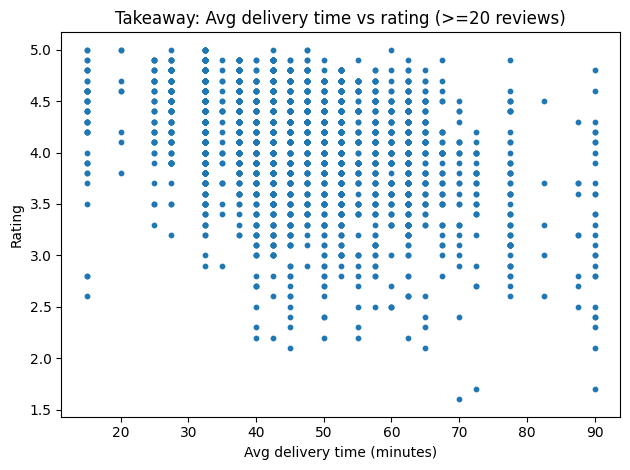

In [35]:
plt.figure()
plt.scatter(time_vs_rating["avg_delivery_minutes"], time_vs_rating["ratings"], s=10)
plt.title("Takeaway: Avg delivery time vs rating (>=20 reviews)")
plt.xlabel("Avg delivery time (minutes)")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()
